# Ckecking the GPU :

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.utils import shuffle
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13745145679567716844
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 860055211469220563
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Import libraries :

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

# Import data :

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [118]:
data = pd.read_csv("/content/drive/MyDrive/x.csv" , dtype="string")
data.columns=['col1','tweet']
data.head()

,col1,tweet
0,775206,چه جالب حالا گوه نخور
1,913043,عطر یاسآواز نسیمرقص شاپرک هاانوار عاشقانه ی آفتابگویند سلامصبح زیبایتان بخیرامروز و هر روزتان بکام صبح بخير
2,197016,نقدی مردم حق انتقاد دارن و به هیچ وجه تهدید نمیشن تو این مملکت سگها هم ازدست شما آسایش ندارن چه برسه به آدماضمنا اینم چندتا نمونه از افرادی که بخاطر انتقاد تهدید نشدن اسماعیل بخشی سپیده قلیان امیرحسین میراسماعیلی هنگامه شهیدی گلرخ ایرایی آتنا دائمی دختران خیابان انقلاب
3,41467,کسی هست واسه سکس چت پول بده
4,769431,دوباره فضول رهبر موقت که به حجاب مردم گیر میده شماره ماشینش هم افتاده دوربین ما اسلحه ما


In [119]:
data.shape

(249981, 2)

In [120]:
data.col1.nunique()

249981

In [121]:
data=data.drop(['col1'],axis=1)

In [122]:
pd.options.display.max_colwidth=1000

In [123]:
data.head()

,tweet
0,چه جالب حالا گوه نخور
1,عطر یاسآواز نسیمرقص شاپرک هاانوار عاشقانه ی آفتابگویند سلامصبح زیبایتان بخیرامروز و هر روزتان بکام صبح بخير
2,نقدی مردم حق انتقاد دارن و به هیچ وجه تهدید نمیشن تو این مملکت سگها هم ازدست شما آسایش ندارن چه برسه به آدماضمنا اینم چندتا نمونه از افرادی که بخاطر انتقاد تهدید نشدن اسماعیل بخشی سپیده قلیان امیرحسین میراسماعیلی هنگامه شهیدی گلرخ ایرایی آتنا دائمی دختران خیابان انقلاب
3,کسی هست واسه سکس چت پول بده
4,دوباره فضول رهبر موقت که به حجاب مردم گیر میده شماره ماشینش هم افتاده دوربین ما اسلحه ما


# Cleaning the data

In [11]:
import re
def tokenizer_txt(text):
    text = re.sub(b'\u200c'.decode("utf-8", "strict"), " ", text)   
    text = re.sub('\n', ' ', text)
    text = re.sub('[ ]+', ' ', text)
    text = re.sub('\.', ' .', text)
    text = re.sub('\،', ' ،', text)
    text = re.sub('\؛ ', ' ؛', text)
    text = re.sub('\؟ ', ' ؟', text)
    text = re.sub('\"',' ',text)
    text = re.sub('\'','',text)
    text = re.sub('\. \. \.', '...', text)

    unique_words = dict.fromkeys(text.split())
    return ' '.join(unique_words)
  

In [125]:
data.isna().sum()

tweet    201
dtype: int64

In [12]:
data.dropna(inplace=True)
data['tweet'] = data['tweet'].apply(tokenizer_txt)

In [13]:
texts = data['tweet']

In [14]:
tweet_lenghs = [len(tweet.split()) for tweet in texts]

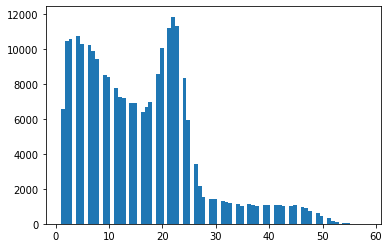

In [15]:
plt.hist(tweet_lenghs, bins=80)
plt.show()

## Tokenize 

In [111]:
#We decided to work with the first 1000 longest tweets to accelerate the learning speed

keys = texts.str.len().sort_values(ascending = False).keys()[:1000]
tweets = data[data.index.isin(keys)].reset_index(drop = True)['tweet']
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(tweets)
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)

Total number of words:  15477


In [112]:
print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("مبارک: ", tokenizer.word_index['مبارک'])
print("فرانسه: ", tokenizer.word_index['فرانسه'])

Total number of words:  15477
Word: ID
------------
<oov>:  1
مبارک:  2657
فرانسه:  1866


## turn into n-grams

In [113]:
input_sequences = []
for line in tweets:
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("Total input sequences: ", len(input_sequences))

Total input sequences:  46330


## padding

In [114]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       1320,   26,  159], dtype=int32)

In [115]:
max_sequence_len

58

## prepare network input and labels

In [116]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

In [22]:
print(xs[1])
print(labels[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1320
   26]
159


## Model Configuration

In [23]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))

    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    axs[0].set_title('Loss')

    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')

    axs[1].set_title('Accuracy')
    plt.show()

In [24]:
model = tf.keras.Sequential()

model.add(Embedding(total_words, 32, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(total_words, activation='softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 57, 32)            495264    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 15477)             1006005   
                                                                 
Total params: 1,517,909
Trainable params: 1,517,909
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(xs, labels, epochs=40, verbose=1)

Epoch 1/40
1448/1448 [==============================] - 26s 12ms/step - loss: 9.0021 - accuracy: 0.0150
Epoch 2/40
1448/1448 [==============================] - 18s 13ms/step - loss: 8.3581 - accuracy: 0.0216
Epoch 3/40
1448/1448 [==============================] - 13s 9ms/step - loss: 7.4130 - accuracy: 0.0387
Epoch 4/40
1448/1448 [==============================] - 20s 14ms/step - loss: 6.2869 - accuracy: 0.0675
Epoch 5/40
1448/1448 [==============================] - 14s 10ms/step - loss: 5.3044 - accuracy: 0.1234
Epoch 6/40
1448/1448 [==============================] - 15s 10ms/step - loss: 4.5314 - accuracy: 0.2064
Epoch 7/40
1448/1448 [==============================] - 13s 9ms/step - loss: 3.9576 - accuracy: 0.2834
Epoch 8/40
1448/1448 [==============================] - 14s 9ms/step - loss: 3.5554 - accuracy: 0.3424
Epoch 9/40
1448/1448 [==============================] - 15s 10ms/step - loss: 3.2391 - accuracy: 0.3915
Epoch 10/40
1448/1448 [==============================] - 17s 12ms/s

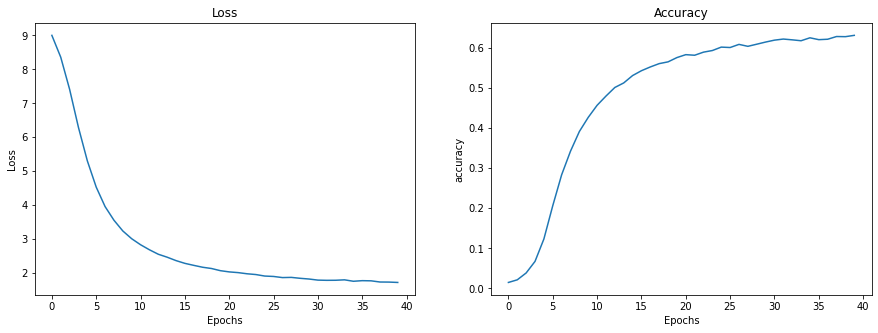

In [27]:
plot_model(history)

## Predicting the next word by the first model

In [28]:
seed_text = "پس"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0).argmax()
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

پس منتظرچه هستیدوقتی


________

In [127]:
model2 = tf.keras.Sequential()

model2.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model2.add(Bidirectional(GRU(30)))
model2.add(Dense(total_words, activation='softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [126]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 57, 100)           1547700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 60)               23760     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 15477)             944097    
                                                                 
Total params: 2,515,557
Trainable params: 2,515,557
Non-trainable params: 0
_________________________________________________________________


In [29]:
history2 = model2.fit(xs, labels, batch_size=128 , epochs=40, verbose=1)

Epoch 1/40
362/362 [==============================] - 7s 11ms/step - loss: 9.0057 - accuracy: 0.0134
Epoch 2/40
362/362 [==============================] - 4s 11ms/step - loss: 8.2117 - accuracy: 0.0207
Epoch 3/40
362/362 [==============================] - 4s 11ms/step - loss: 7.1816 - accuracy: 0.0428
Epoch 4/40
362/362 [==============================] - 4s 11ms/step - loss: 5.9255 - accuracy: 0.0863
Epoch 5/40
362/362 [==============================] - 4s 11ms/step - loss: 4.8162 - accuracy: 0.1679
Epoch 6/40
362/362 [==============================] - 4s 11ms/step - loss: 3.9753 - accuracy: 0.2697
Epoch 7/40
362/362 [==============================] - 4s 11ms/step - loss: 3.4421 - accuracy: 0.3569
Epoch 8/40
362/362 [==============================] - 4s 12ms/step - loss: 2.9800 - accuracy: 0.4294
Epoch 9/40
362/362 [==============================] - 5s 13ms/step - loss: 2.6689 - accuracy: 0.4837
Epoch 10/40
362/362 [==============================] - 4s 11ms/step - loss: 2.4521 - accura

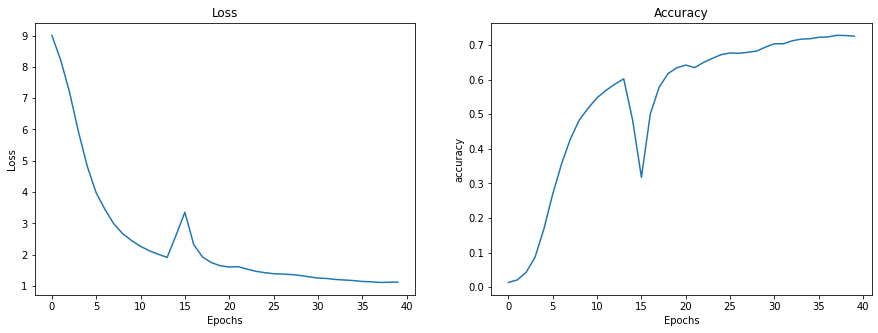

In [30]:
plot_model(history2) 

## Predicting the next word by the second model

In [32]:
seed_text = "شاید"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model2.predict(token_list, verbose=0).argmax()
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

شاید دیده که


___

In [129]:
model3 = tf.keras.Sequential()

model3.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model3.add(Bidirectional(GRU(30)))
model3.add(Dense(total_words, activation='softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [128]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 57, 100)           1547700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 60)               23760     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 15477)             944097    
                                                                 
Total params: 2,515,557
Trainable params: 2,515,557
Non-trainable params: 0
_________________________________________________________________


In [33]:
history3 = model3.fit(xs, labels, batch_size=128 , epochs=50, verbose=1)

Epoch 1/50
362/362 [==============================] - 7s 12ms/step - loss: 9.0743 - accuracy: 0.0120
Epoch 2/50
362/362 [==============================] - 4s 11ms/step - loss: 8.2700 - accuracy: 0.0216
Epoch 3/50
362/362 [==============================] - 4s 12ms/step - loss: 7.2652 - accuracy: 0.0430
Epoch 4/50
362/362 [==============================] - 5s 13ms/step - loss: 6.0178 - accuracy: 0.0870
Epoch 5/50
362/362 [==============================] - 5s 14ms/step - loss: 4.8849 - accuracy: 0.1669
Epoch 6/50
362/362 [==============================] - 4s 11ms/step - loss: 4.0146 - accuracy: 0.2745
Epoch 7/50
362/362 [==============================] - 4s 11ms/step - loss: 3.3946 - accuracy: 0.3690
Epoch 8/50
362/362 [==============================] - 4s 11ms/step - loss: 2.9566 - accuracy: 0.4425
Epoch 9/50
362/362 [==============================] - 5s 13ms/step - loss: 2.6555 - accuracy: 0.4891
Epoch 10/50
362/362 [==============================] - 4s 11ms/step - loss: 2.4242 - accura

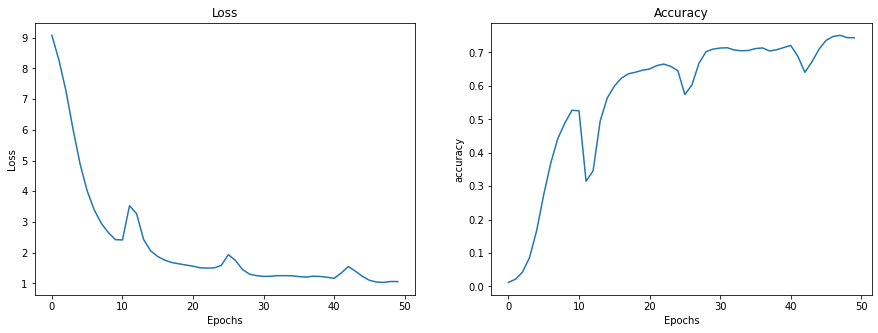

In [34]:
plot_model(history3) 

## Predicting the next word by the third model

In [86]:
seed_text = "روزی"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model3.predict(token_list, verbose=0).argmax()
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

روزی فرا میرسدکه


____

In [131]:
model4 = tf.keras.Sequential()

model4.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model4.add(Bidirectional(LSTM(30)))
model4.add(Dense(total_words, activation='softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model4.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [130]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 57, 100)           1547700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 60)               31440     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 15477)             944097    
                                                                 
Total params: 2,523,237
Trainable params: 2,523,237
Non-trainable params: 0
_________________________________________________________________


In [36]:
history4 = model4.fit(xs, labels, batch_size=128 , epochs=50, verbose=1)

Epoch 1/50
362/362 [==============================] - 7s 12ms/step - loss: 8.9035 - accuracy: 0.0147
Epoch 2/50
362/362 [==============================] - 4s 12ms/step - loss: 8.2507 - accuracy: 0.0179
Epoch 3/50
362/362 [==============================] - 4s 12ms/step - loss: 7.5815 - accuracy: 0.0276
Epoch 4/50
362/362 [==============================] - 4s 12ms/step - loss: 6.6825 - accuracy: 0.0521
Epoch 5/50
362/362 [==============================] - 4s 12ms/step - loss: 5.7208 - accuracy: 0.1031
Epoch 6/50
362/362 [==============================] - 4s 11ms/step - loss: 4.8553 - accuracy: 0.1937
Epoch 7/50
362/362 [==============================] - 4s 12ms/step - loss: 4.1228 - accuracy: 0.2970
Epoch 8/50
362/362 [==============================] - 4s 12ms/step - loss: 3.5417 - accuracy: 0.3954
Epoch 9/50
362/362 [==============================] - 4s 12ms/step - loss: 3.0946 - accuracy: 0.4656
Epoch 10/50
362/362 [==============================] - 4s 12ms/step - loss: 2.7509 - accura

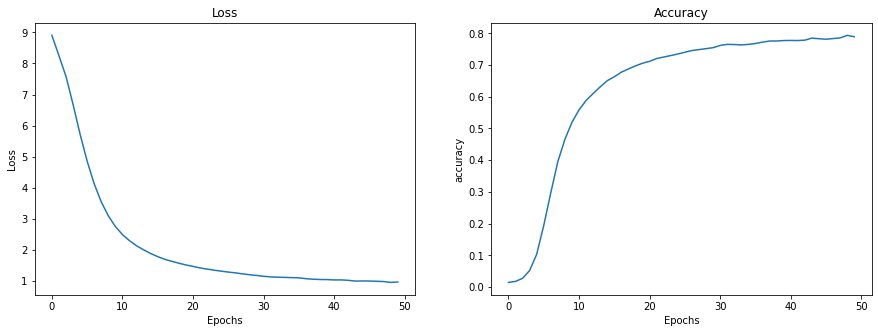

In [37]:
plot_model(history4) 

## Predicting the next word by the fourth model

In [63]:
seed_text = "کاش"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model4.predict(token_list, verbose=0).argmax()
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

کاش شما میدانستید
